# Automatic Centerlines Extraction


First, extract the coronary artery centerlines from your dataset using the method described in 
[Coronary artery centerline extraction in cardiac CT angiography using a CNN-based orientation classifier (Wolternik et al., 2019b)](https://www.sciencedirect.com/science/article/pii/S1361841518308491). For now, CCTA scans from `<dataset_dir>` are matched with the patterns `*.mhd`
and `*_image.nii.gz`. 

```bash
source centerlines_autoextract.sh <dataset_dir> <output_dir>
```

For every `datapoint_X` in `<dataset_dir>`, this command creates files `<output_dir>/<datapoint_X>/vessel0.txt`,
`<output_dir>/<datapoint_X>/vessel1.txt` etc., where each `vessel<N>.txt` file corresponds to a discovered coranary 
artery vessel and it contains an array of 4D points (3D XYZ coordinates + artery lumen radius estimate).

## Create the preproecessed dataset

We save CCTAs and centerliens masks as `numpy` arrays, which can then be loaded partially on-demand to reduce memory footprint
as [memmaps](https://numpy.org/doc/stable/reference/generated/numpy.memmap.html). Numpy memmaps are also supported by `batchgenerators`,
the library used used for augmentations and dataloading.

A preprocessed CCTA and its centerlines mask is saved as a 4D array of shape (Width, Height, Depth, 2). The last dimension
contains 2 values: the HU attenuation of the voxel at that location, and a binary mask centerline presence or absence.

We also save image metadata as dictionaries; for each file e.g. `ASOCA-002.mhd`, `data_u.create_patient()` creates files 
`ASOCA-002.npy` and `ASOCA-002_meta.pkl`. 

In [1]:
%cd ../

%config InlineBackend.figure_format = 'retina'

/home/marco/thesis_project/contrast-gan-3D


Adjust the variables in the following cell to match your setup:

In [2]:
from pathlib import Path
from pprint import pprint

import numpy as np
from matplotlib import pyplot as plt

from contrast_gan_3D.constants import VMAX, VMIN
from contrast_gan_3D.data import utils as data_u
from contrast_gan_3D.utils import io_utils, logging_utils
from contrast_gan_3D.utils import visualization as viz

logging_utils.set_project_loggers_level(level="DEBUG")

contrast_gan_3D.utils.geometry: INFO -> DEBUG
contrast_gan_3D.utils.io_utils: INFO -> DEBUG
contrast_gan_3D.data.utils: INFO -> DEBUG
contrast_gan_3D.utils.visualization: INFO -> DEBUG


In [3]:
DATA_ROOT = Path("/home/marco/data")

DATASET = "MMWHS/ct_test"
# DATASET = "MMWHS/ct_train"
# DATASET = "ASOCA_Philips/images"

dataset_id = DATASET.split("/")[0]

DATASET_DIR = (DATA_ROOT / DATASET).resolve()
CENTERLINES_DIR = (DATA_ROOT / "auto_centerlines" / dataset_id).resolve()

OUTPUT_DIR = DATA_ROOT / "preproc" / dataset_id
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

print(str(DATASET_DIR), DATASET_DIR.is_dir())
print(str(CENTERLINES_DIR), CENTERLINES_DIR.is_dir())
print(str(OUTPUT_DIR))

/home/roel/data/MMWHS/ct_test True
/home/marco/data/auto_centerlines/MMWHS True
/home/marco/data/preproc/MMWHS


In [4]:
cctas = sorted(
    list(DATASET_DIR.glob("*.mhd")) + list(DATASET_DIR.glob("*_image.nii.gz"))
)
centerlines = [
    d
    for ccta in cctas
    if ((d := next(CENTERLINES_DIR.glob(f"*{io_utils.stem(ccta)}"))).is_dir())
]
print(f"Found {len(cctas)} CCTAs and {len(centerlines)} centerlines")

zipped = list(zip(cctas, centerlines))
pprint(zipped[:3])

Found 40 CCTAs and 40 centerlines
[(PosixPath('/home/roel/data/MMWHS/ct_test/ct_test_2001_image.nii.gz'),
  PosixPath('/home/marco/data/auto_centerlines/MMWHS/ct_test_2001_image')),
 (PosixPath('/home/roel/data/MMWHS/ct_test/ct_test_2002_image.nii.gz'),
  PosixPath('/home/marco/data/auto_centerlines/MMWHS/ct_test_2002_image')),
 (PosixPath('/home/roel/data/MMWHS/ct_test/ct_test_2003_image.nii.gz'),
  PosixPath('/home/marco/data/auto_centerlines/MMWHS/ct_test_2003_image'))]


In [5]:
for ccta_path, centerlines_dir in zipped:
    ccta_name = io_utils.stem(ccta_path)
    if io_utils.stem(centerlines_dir) == ccta_name:
        if (OUTPUT_DIR / f"{ccta_name}.npy").is_file():
            print(f"Skip already preprocessed {str(ccta_path)!r}")
            continue
        data_u.create_patient(
            ccta_path, centerlines_dir, centerlines_dir / "ostia.xml", OUTPUT_DIR
        )
        print()
    else:
        print(f"**No centerlines for {str(ccta_path)!r}**")

Skip already preprocessed '/home/roel/data/MMWHS/ct_test/ct_test_2001_image.nii.gz'
Skip already preprocessed '/home/roel/data/MMWHS/ct_test/ct_test_2002_image.nii.gz'
Skip already preprocessed '/home/roel/data/MMWHS/ct_test/ct_test_2003_image.nii.gz'
Skip already preprocessed '/home/roel/data/MMWHS/ct_test/ct_test_2004_image.nii.gz'
Skip already preprocessed '/home/roel/data/MMWHS/ct_test/ct_test_2005_image.nii.gz'
Skip already preprocessed '/home/roel/data/MMWHS/ct_test/ct_test_2006_image.nii.gz'
Skip already preprocessed '/home/roel/data/MMWHS/ct_test/ct_test_2007_image.nii.gz'
Skip already preprocessed '/home/roel/data/MMWHS/ct_test/ct_test_2008_image.nii.gz'
Skip already preprocessed '/home/roel/data/MMWHS/ct_test/ct_test_2009_image.nii.gz'
Skip already preprocessed '/home/roel/data/MMWHS/ct_test/ct_test_2010_image.nii.gz'
Skip already preprocessed '/home/roel/data/MMWHS/ct_test/ct_test_2011_image.nii.gz'
Skip already preprocessed '/home/roel/data/MMWHS/ct_test/ct_test_2012_image.

/home/marco/data/preproc/MMWHS/ct_train_1009_image.npy
(512, 512, 293, 2)


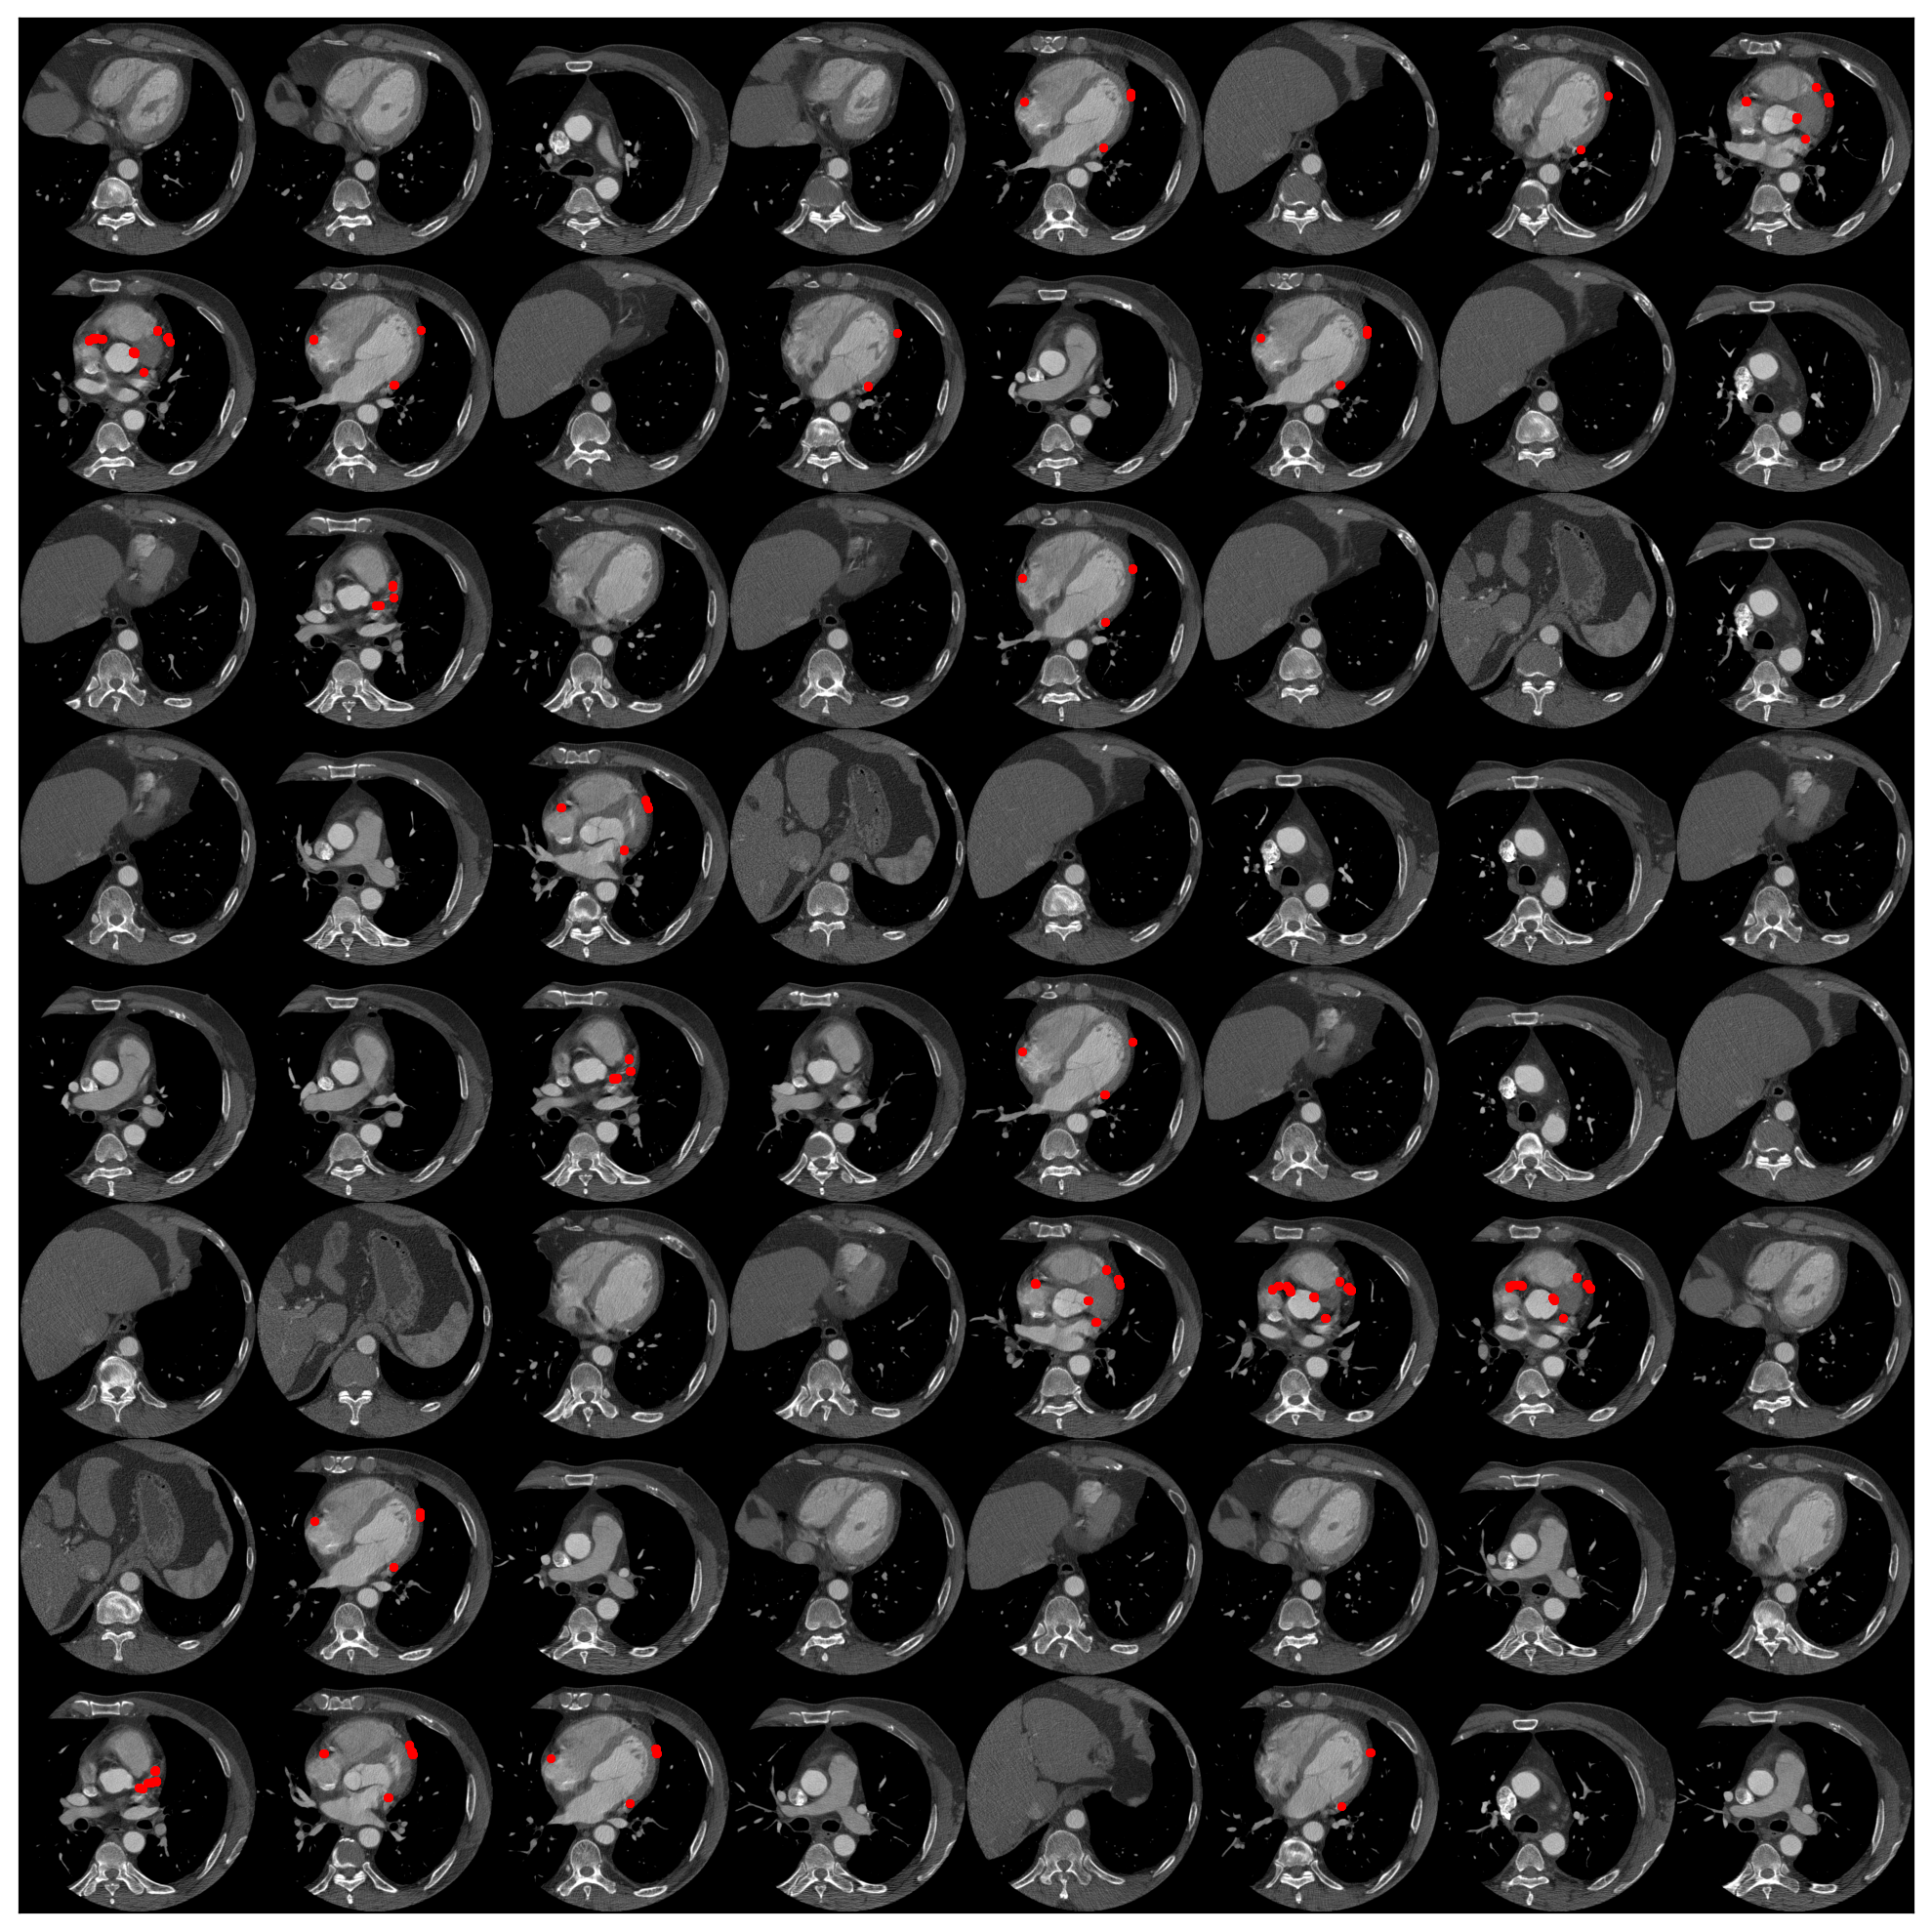

In [7]:
# show one image to prove things went right

rng = np.random.default_rng()
patient = rng.choice(list(OUTPUT_DIR.glob("*.npy")))
print(patient)

scan, meta = data_u.load_patient(str(patient.parent / io_utils.stem(patient)))
print(scan.shape)

z_ids = rng.choice(scan.shape[2], size=64)

fig = viz.plot_axial_slices_and_centerlines(
    scan[..., z_ids, 0],
    scan[..., z_ids, 1],
    **{"normalize": True, "value_range": (VMIN, VMAX)}
)
plt.show()
plt.close(fig)